In [2]:
import pandas as pd
import numpy as np
import re
import string
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from collections import defaultdict, Counter
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import re
import html
import matplotlib.pyplot as plt


In [3]:
# Preprocessing models
nltk.download('wordnet')
nltk.download('omw-1.4')
wn.synsets('test')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yifeishi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yifeishi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[Synset('trial.n.02'),
 Synset('test.n.02'),
 Synset('examination.n.02'),
 Synset('test.n.04'),
 Synset('test.n.05'),
 Synset('test.n.06'),
 Synset('test.v.01'),
 Synset('screen.v.01'),
 Synset('quiz.v.01'),
 Synset('test.v.04'),
 Synset('test.v.05'),
 Synset('test.v.06'),
 Synset('test.v.07')]

In [4]:
# Load models
nlp = spacy.load("en_core_web_sm")

# Dataset Overview

In [5]:
# Load the dataset
df = pd.read_csv("BooksDatasetClean.csv")
print(f"Original dataset shape: {df.shape}")
df.head()

Original dataset shape: (103063, 8)


,Title,Authors,Description,Category,Publisher,Price Starting With ($),Publish Date (Month),Publish Date (Year)
0,Goat Brothers,"By Colton, Larry",NaN,"History , General",Doubleday,8.79,January,1993
1,The Missing Person,"By Grumbach, Doris",NaN,"Fiction , General",Putnam Pub Group,4.99,March,1981
2,Don't Eat Your Heart Out Cookbook,"By Piscatella, Joseph C.",NaN,"Cooking , Reference",Workman Pub Co,4.99,September,1983
3,When Your Corporate Umbrella Begins to Leak: A...,"By Davis, Paul D.",NaN,NaN,Natl Pr Books,4.99,April,1991
4,Amy Spangler's Breastfeeding : A Parent's Guide,"By Spangler, Amy",NaN,NaN,Amy Spangler,5.32,February,1997


In [6]:
# Eliminate rows with missing category & description
df = df.dropna(subset=['Category', 'Description'])
print(f"After removing missing categories/descriptions: {df.shape}")

After removing missing categories/descriptions: (65296, 8)


In [7]:
# Add book_id for tracking
df['book_id'] = df.index

In [8]:
# keep only book_id, description, category
df = df[['book_id', 'Description', 'Category']]
df.head()

,book_id,Description,Category
7,7,Collects poems written by the eleven-year-old ...,"Poetry , General"
8,8,The Russian author offers an affectionate chro...,"Biography & Autobiography , General"
10,10,"A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets"
11,11,"Deadly germs sprayed in shopping malls, bomb-l...","Technology & Engineering , Military Science"
13,13,"""The Bible and the social and moral consequenc...","Religion , Biblical Biography , General"


In [9]:
# Create a new list, then put each unique category (separated by comma) into the list
category_list = []
for categories in df['Category']:
    for category in categories.split(','):
        category = category.strip()
        if category not in category_list:
            category_list.append(category)

len(category_list)

2026

In [10]:
# check top 10 frequent categories in the list
category_counter = Counter()
for categories in df['Category']:
    for category in categories.split(','):
        category = category.strip()
        category_counter[category] += 1
category_counter.most_common(10)

[('General', 25721),
 ('Fiction', 17721),
 ('Juvenile Fiction', 6437),
 ('Religion', 3686),
 ('Romance', 3491),
 ('Cooking', 2890),
 ('Juvenile Nonfiction', 2665),
 ('History', 2583),
 ('Business & Economics', 2542),
 ('Historical', 2356)]

Category 'General' appears for almost 40% of the valid records but provides no discriminative information for classification, need to remove.

Other than removing noise, we need to preprocess categories in the dataset before clustering, which includes:
    - Remove 'General' category
    - Remove parentheses and their contents
    - Remove numbers
    - Normalize punctuation
    - Lowercase


# Label Preprocessing

In [11]:
def preprocess_category(cat):
    if pd.isna(cat): return None
    cat = str(cat).strip()
    
    # FIRST: Replace & with , to treat it as separator
    cat = cat.replace(' & ', ', ')
    
    # THEN: Split on comma
    categories = [c.strip() for c in cat.split(',')]
    
    cleaned = []
    for c in categories:
        if c.lower().strip() == 'general': 
            continue
        c = re.sub(r'\(.*?\)', '', c)
        c = re.sub(r'[()]|\d+', '', c)
        c = c.replace("'s", "s").replace("-", " ")  # Remove & replacement here
        c = c.lower().strip()
        c = ' '.join(c.split())
        if c: 
            cleaned.append(c)
    
    return ', '.join(cleaned) if cleaned else None

In [12]:
# Apply preprocessing
df['Category_Cleaned'] = df['Category'].apply(preprocess_category)

In [13]:
# Remove rows where all categories were filtered out
df = df[df['Category_Cleaned'].notna()]
print(f"After cleaning (removed 'General' and invalid categories): {df.shape}")

After cleaning (removed 'General' and invalid categories): (65296, 4)


In [14]:
# Show sample of cleaned categories
print("\nSample of original vs cleaned categories:")
df[['Category', 'Category_Cleaned']].head(10)


Sample of original vs cleaned categories:


,Category,Category_Cleaned
7,"Poetry , General",poetry
8,"Biography & Autobiography , General","biography, autobiography"
10,"Health & Fitness , Diet & Nutrition , Diets","health, fitness, diet, nutrition, diets"
11,"Technology & Engineering , Military Science","technology, engineering, military science"
13,"Religion , Biblical Biography , General","religion, biblical biography"
14,"Biography & Autobiography , Personal Memoirs","biography, autobiography, personal memoirs"
19,"Political Science , General",political science
21,"Pets , Cats , General","pets, cats"
26,"Political Science , General",political science
27,"Fiction , General",fiction


Noticed different taxnomies exists in the category (i.e. fiction is a type of literature, but religion is the theme of the book), we need to discuss whether further rul-based clustering needs to be implemented.

# Label Lemmatization

In [15]:
# Explode categories - create one row per category per book
df_exploded = df.copy()
df_exploded['Category_Split'] = df_exploded['Category_Cleaned'].str.split(', ')
df_exploded = df_exploded.explode('Category_Split')
df_exploded = df_exploded[df_exploded['Category_Split'].notna()]
df_exploded = df_exploded.reset_index(drop=True)

In [16]:
print(f"After exploding categories: {df_exploded.shape}")
print(f"Unique categories: {df_exploded['Category_Split'].nunique()}")

After exploding categories: (170599, 5)
Unique categories: 2131


In [17]:
df_exploded[['book_id', 'Description', 'Category_Split']].head(10)

,book_id,Description,Category_Split
0,7,Collects poems written by the eleven-year-old ...,poetry
1,8,The Russian author offers an affectionate chro...,biography
2,8,The Russian author offers an affectionate chro...,autobiography
3,10,"A humor classic, this tongue-in-cheek diet pla...",health
4,10,"A humor classic, this tongue-in-cheek diet pla...",fitness
5,10,"A humor classic, this tongue-in-cheek diet pla...",diet
6,10,"A humor classic, this tongue-in-cheek diet pla...",nutrition
7,10,"A humor classic, this tongue-in-cheek diet pla...",diets
8,11,"Deadly germs sprayed in shopping malls, bomb-l...",technology
9,11,"Deadly germs sprayed in shopping malls, bomb-l...",engineering


In [18]:
# Lemmatize each category
def lemmatize_category(cat):
    """
    Lemmatize category and use lemmatized form directly as canonical.
    For multi-word categories, lemmatize each word and reconstruct.
    """
    if pd.isna(cat) or not cat:
        return None
    
    # Process with spaCy
    doc = nlp(cat)
    
    # Lemmatize each token (excluding punctuation)
    lemmas = [token.lemma_ for token in doc if not token.is_punct]
    
    # Reconstruct with spaces
    canonical = " ".join(lemmas).strip()
    
    return canonical if canonical else None

In [19]:
df_exploded['Category_Lemmatized'] = df_exploded['Category_Split'].apply(lemmatize_category)

In [20]:
df_exploded.head()

,book_id,Description,Category,Category_Cleaned,Category_Split,Category_Lemmatized
0,7,Collects poems written by the eleven-year-old ...,"Poetry , General",poetry,poetry,poetry
1,8,The Russian author offers an affectionate chro...,"Biography & Autobiography , General","biography, autobiography",biography,biography
2,8,The Russian author offers an affectionate chro...,"Biography & Autobiography , General","biography, autobiography",autobiography,autobiography
3,10,"A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets","health, fitness, diet, nutrition, diets",health,health
4,10,"A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets","health, fitness, diet, nutrition, diets",fitness,fitness


In [21]:
# Remove any None values
df_exploded = df_exploded[df_exploded['Category_Lemmatized'].notna()].copy()

In [22]:
sample_lemma = df_exploded[['Category_Split', 'Category_Lemmatized']].drop_duplicates().head(20)
print(sample_lemma)

        Category_Split Category_Lemmatized
0               poetry              poetry
1            biography           biography
2        autobiography       autobiography
3               health              health
4              fitness             fitness
5                 diet                diet
6            nutrition           nutrition
7                diets                diet
8           technology          technology
9          engineering         engineering
10    military science    military science
11            religion            religion
12  biblical biography  biblical biography
15    personal memoirs     personal memoir
16   political science   political science
17                pets                 pet
18                cats                 cat
20             fiction             fiction
21             history             history
22            military            military


In [23]:
print(f"unique categories after lemmatization: {df_exploded['Category_Lemmatized'].nunique()}")
print(f"total book-category pairs: {len(df_exploded)}")

unique categories after lemmatization: 2083
total book-category pairs: 170599


In [24]:
# Find cases where multiple original forms map to same lemma
lemma_groups = df_exploded.groupby('Category_Lemmatized')['Category_Split'].unique()

In [25]:
# Show some interesting merges
merge_examples = []
for lemma, originals in lemma_groups.items():
    if len(originals) > 1:
        merge_examples.append({
            'lemmatized': lemma,
            'originals': list(originals),
            'count': len(originals)
        })

In [26]:
# Sort by number of variants merged
merge_examples_df = pd.DataFrame(merge_examples).sort_values('count', ascending=False)

In [27]:
print("\nTop 15 lemmatization merges:")
for idx, row in merge_examples_df.head(15).iterrows():
    print(f"\n'{row['lemmatized']}' ← {row['count']} variants:")
    print(f"  {', '.join(row['originals'][:5])}", end='')
    if row['count'] > 5:
        print(f" ... (+{row['count']-5} more)")
    else:
        print()


Top 15 lemmatization merges:

'act' ← 3 variants:
  acting, act, acts

'rock' ← 2 variants:
  rock, rocks

'mystery' ← 2 variants:
  mystery, mysteries

'parent' ← 2 variants:
  parents, parent

'pediatric' ← 2 variants:
  pediatrics, pediatric

'physician' ← 2 variants:
  physicians, physician

'pictorial' ← 2 variants:
  pictorials, pictorial

'presentation' ← 2 variants:
  presentations, presentation

'record' ← 2 variants:
  recording, records

'review' ← 2 variants:
  reviews, review

'revolutionary period' ← 2 variants:
  revolutionary period, revolutionary periods

'security' ← 2 variants:
  security, securities

'meditation' ← 2 variants:
  meditations, meditation

'sound' ← 2 variants:
  sounds, sound

'speech' ← 2 variants:
  speech, speeches


In [28]:
# Update category frequency with lemmatized versions
category_frequency = df_exploded['Category_Lemmatized'].value_counts()

In [29]:
print(f"\n\nTop 20 most frequent lemmatized categories:")
print(category_frequency.head(20))



Top 20 most frequent lemmatized categories:
Category_Lemmatized
fiction                17721
juvenile fiction        6437
religion                3697
romance                 3590
cook                    2927
history                 2733
juvenile nonfiction     2665
economic                2627
business                2601
mystery                 2525
historical              2356
thriller                2299
biography               2290
autobiography           2290
detective               2273
health                  1997
family                  1859
political science       1850
reference               1765
literary                1764
Name: count, dtype: int64


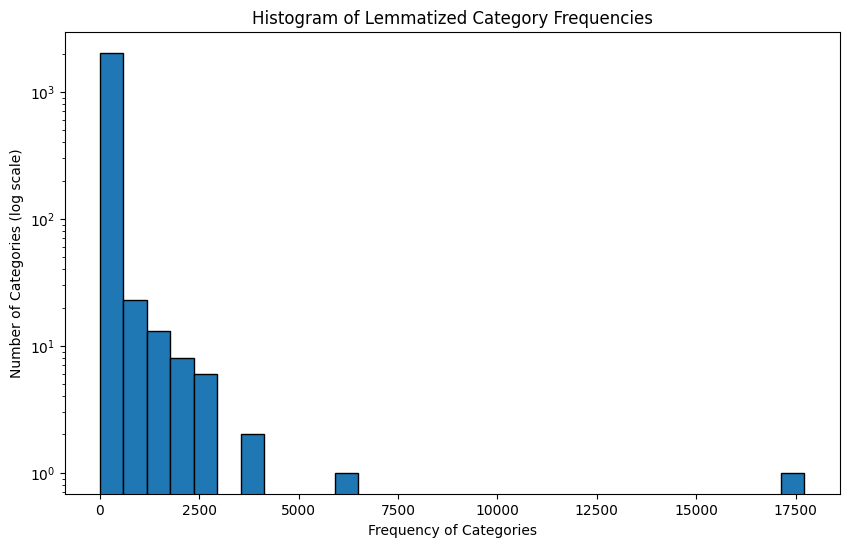

In [31]:
# generate a histogram of lemmatized category frequencies, where x-axis is frequency bins and y-axis is number of categories in each bin
plt.figure(figsize=(10,6))
plt.hist(category_frequency, bins=30, log=True, edgecolor='black')
plt.title('Histogram of Lemmatized Category Frequencies')
plt.xlabel('Frequency of Categories')
plt.ylabel('Number of Categories (log scale)')
plt.savefig('category_frequency_histogram.png')
plt.show()

In [29]:
# Get all unique categories for next steps
all_categories = df_exploded['Category_Lemmatized'].unique().tolist()
print(f"\nTotal unique categories: {len(all_categories)}")


Total unique categories: 2083


In [30]:
all_categories[:10]

['poetry',
 'biography',
 'autobiography',
 'health',
 'fitness',
 'diet',
 'nutrition',
 'technology',
 'engineering',
 'military science']

In [31]:
# Check for any remaining inconsistencies
duplicates = df_exploded.groupby(['book_id', 'Category_Lemmatized']).size()
duplicates = duplicates[duplicates > 1]
if len(duplicates) > 0:
    print(f"\nWarning: Found {len(duplicates)} book-category duplicates after lemmatization")
else:
    print("\n✓ No duplicates found - lemmatization successful")

In [32]:
# Remove duplicate book-category pairs after lemmatization
print(f"Before deduplication: {len(df_exploded):,} rows")

df_exploded = df_exploded.drop_duplicates(subset=['book_id', 'Category_Lemmatized']).reset_index(drop=True)

print(f"After deduplication: {len(df_exploded):,} rows")

Before deduplication: 170,599 rows
After deduplication: 170,114 rows


# Hypernym-Based Label Clustering

If we want to group different sports game into the general term 'sports', and we do not have the word 'sports' in our corpus, we need to use a hypernym dictionary for further merging

In [33]:
# filter out categories with very low frequency (e.g., less than 4 books)
min_frequency = 4
category_counts = df_exploded['Category_Lemmatized'].value_counts()
filtered_categories = category_counts[category_counts >= min_frequency].index.tolist()
df_exploded = df_exploded[df_exploded['Category_Lemmatized'].isin(filtered_categories)]

In [34]:
print(f"After filtering low-frequency categories: {len(df_exploded):,} rows")

After filtering low-frequency categories: 169,023 rows


In [35]:
# show current list of categories
all_categories = df_exploded['Category_Lemmatized'].unique().tolist()
all_categories[:10]

['poetry',
 'biography',
 'autobiography',
 'health',
 'fitness',
 'diet',
 'nutrition',
 'technology',
 'engineering',
 'military science']

In [36]:
# Define protected categories that should not be merged based on the current list
PROTECTED_CATEGORIES = {
    # Fiction types
    'fiction', 'science fiction', 'fantasy', 'mystery and detective', 'romance', 
    'thriller', 'suspense', 'historical', 'horror', 'western', 'literary',
    # Age-specific
    'juvenile fiction', 'juvenile nonfiction', 'young adult fiction', 
    'young adult nonfiction', 'adult',
    # Major nonfiction genres
    'biography and autobiography', 'history', 'religion', 'philosophy',
    'science', 'reference', 'education', 'business and economic',
    # Art forms
    'poetry', 'drama', 'essay', 'short story',
    # Core subject areas
    'political science', 'social science', 'psychology', 'medical',
    'technology and engineering', 'mathematics', 'computer',
}
print(f"Protected categories: {len(PROTECTED_CATEGORIES)}")

Protected categories: 35


In [37]:
def get_meaningful_hypernym(word, max_depth=4):
    """
    Get domain-meaningful hypernym using smarter WordNet traversal.
    """
    # Manual domain-specific mappings (override WordNet) - CHECK FIRST
    MANUAL_HYPERNYMS = {
        # Sports (explicit mapping to avoid WordNet inconsistencies)
        'baseball': 'sport',
        'basketball': 'sport',
        'football': 'sport',
        'golf': 'sport',
        'soccer': 'sport',
        'tennis': 'sport',
        'hockey': 'sport',
        'volleyball': 'sport',
        'boxing': 'sport',
        'wrestling': 'sport',
        'swimming': 'sport',
        'cycling': 'sport',
        'running': 'sport',
        'fishing': 'sport',
        'sport and recreation': 'sport',
        
        # Food/Cooking
        'cooking': 'food',
        'cook': 'food',
        'pasta': 'food',
        'dessert': 'food',
        'beverage': 'food',
        'wine': 'food',
        'bread': 'food',
        'soup': 'food',
        'salad': 'food',
        
        # Religion
        'christian': 'religion',
        'religious': 'religion',
        'christianity': 'religion',
        
        # Fiction/Mystery - map to fiction parent
        'mystery': 'fiction',
        'thriller': 'fiction',
        'contemporary': 'fiction',
        
        # Social sciences
        'historical': 'history',
        'political': 'political science',
        'psychology': 'social science',
        'sociology': 'social science',
    }
    
    # Check manual mapping first
    if word in MANUAL_HYPERNYMS:
        return MANUAL_HYPERNYMS[word]
    
    # Domain-meaningful terms (accept these as hypernyms) - STOP here
    MEANINGFUL_TERMS = {
        # Core categories - STOP at these, don't go higher
        'fiction', 'nonfiction',  # STOP here for literature
        'sport', 'athletics', 'game', 'athletic game', 'field game', 
        'court game', 'ball game', 'outdoor sport', 'contact sport',
        'food', 'dish', 'nutriment', 'course', 'ingredient', 'produce',
        'meal', 'foodstuff', 'beverage', 'drink', 'nourishment',
        'science', 'natural science', 'social science', 'applied science',
        'art', 'fine art', 'music', 'dance', 'performing art', 'visual art',
        'craft', 'hobby', 'health', 'medicine', 'medical specialty',
        'education', 'business', 'religion', 'philosophy', 'travel',
        'animal', 'plant', 'nature', 'technology', 'computer',
        'drama', 'comedy', 'activity', 'diversion', 'entertainment',
        'history', 'political science',
        # Lower-level acceptable terms
        'life science', 'physical science', 'therapy',
        'instruction', 'learning', 'discipline', 'commerce', 'trade',
        'organism', 'living thing', 'flora', 'vehicle', 'building'
    }
    
    # Reject over-general terms
    REJECT_TERMS = {
        'writing', 'written communication', 'literary composition',  # Too general for fiction
        'abstraction', 'entity', 'physical entity', 'object', 'whole', 
        'thing', 'matter', 'substance', 'relation', 'communication',
        'social relation', 'attribute', 'psychological feature', 
        'cognition', 'content', 'message', 'state', 'possession'
    }
    
    # Check if it's a compound in WordNet
    compound_synsets = wn.synsets(word.replace(' ', '_'), pos='n')
    if compound_synsets:
        synsets = compound_synsets
    else:
        # Try first word (head noun for multi-word)
        first_word = word.split()[0]
        synsets = wn.synsets(first_word, pos='n')
    
    if not synsets:
        return None
    
    # Try multiple senses
    for synset in synsets[:3]:
        current = synset
        
        # Traverse up to max_depth
        for depth in range(max_depth + 1):
            hypernyms = current.hypernyms()
            if not hypernyms:
                break
            
            hyper = hypernyms[0]
            hyper_name = hyper.name().split('.')[0].replace('_', ' ')
            
            # Check if should reject first
            if hyper_name in REJECT_TERMS:
                break
            
            # Check if meaningful - STOP here
            if hyper_name in MEANINGFUL_TERMS:
                return hyper_name
            
            current = hyper
    
    return None

In [38]:
# Test on sample
test_words = ['baseball', 'basketball', 'cooking', 'pasta', 'fiction', 'mystery']
print("\nHypernym extraction examples:")
for word in test_words:
    hyper = get_meaningful_hypernym(word)
    print(f"  '{word}' -> '{hyper}'")


Hypernym extraction examples:
  'baseball' -> 'sport'
  'basketball' -> 'sport'
  'cooking' -> 'food'
  'pasta' -> 'food'
  'fiction' -> 'None'
  'mystery' -> 'fiction'


In [39]:
# Build complete hypernym mapping for all frequent categories
hypernym_mapping = {}
unmapped_categories = []
protected_count = 0
manual_count = 0
wordnet_count = 0

for cat in filtered_categories:
    # Skip protected categories
    if cat in PROTECTED_CATEGORIES or cat.lower() in PROTECTED_CATEGORIES:
        hypernym_mapping[cat] = cat
        protected_count += 1
        continue
    
    # All categories are now atomic (no compounds with 'and')
    hyper = get_meaningful_hypernym(cat)
    
    if hyper:
        hypernym_mapping[cat] = hyper
        # Approximate count (manual mappings handled inside function)
        wordnet_count += 1
    else:
        hypernym_mapping[cat] = cat  # Keep as-is
        unmapped_categories.append(cat)

print(f"\nHypernym mapping statistics:")
print(f"  Total categories processed: {len(hypernym_mapping)}")
print(f"  Protected (kept as-is): {protected_count}")
print(f"  Mapped to hypernyms: {len([k for k, v in hypernym_mapping.items() if k != v])}")
print(f"  Unmapped (kept original): {len(unmapped_categories)}")
print(f"\nUnique hypernym labels: {len(set(hypernym_mapping.values()))}")


Hypernym mapping statistics:
  Total categories processed: 1449
  Protected (kept as-is): 31
  Mapped to hypernyms: 547
  Unmapped (kept original): 871

Unique hypernym labels: 931


In [40]:
# Group categories by their hypernym
hypernym_groups = defaultdict(list)
for orig, hyper in hypernym_mapping.items():
    hypernym_groups[hyper].append(orig)

# Sort by number of categories merged
sorted_groups = sorted(hypernym_groups.items(), key=lambda x: len(x[1]), reverse=True)

print("\nTop 15 hypernym groupings (by number of categories merged):\n" + "="*70)
for hyper, originals in sorted_groups[:15]:
    print(f"\n'{hyper}' ← {len(originals)} categories:")
    if len(originals) == 1:
        print(f"  (kept as-is: {originals[0]})")
    else:
        print(f"  {', '.join(originals[:10])}", end='')
        if len(originals) > 10:
            print(f" ... (+{len(originals)-10} more)")
        else:
            print()
            
# Show some unmapped categories for review
if unmapped_categories:
    print(f"\n\nSample unmapped categories (kept as original):")
    for cat in unmapped_categories[:20]:
        print(f"  - {cat}")


Top 15 hypernym groupings (by number of categories merged):

'organism' ← 162 categories:
  detective, self help, reader, animal, woman, christian life, beginner, classic, ethnic, woman sleuth ... (+152 more)

'activity' ← 90 categories:
  recreation, craft, art, adventure, technology, engineering, photography, games, music, study aids ... (+80 more)

'commerce' ← 20 categories:
  business, investment, marketing, business communication, industry, business development, sale, sell, finance, desktop publishing ... (+10 more)

'discipline' ← 19 categories:
  discipline, method, literary criticism, english, trivium, military science, computer science, genealogy, telecommunication, literature ... (+9 more)

'medicine' ← 17 categories:
  specific ingredient, psychotherapy, psychiatry, gerontology, gynecology, oncology, clinical psychology, pharmacology, complementary medicine, endocrinology ... (+7 more)

'food' ← 15 categories:
  cook, nutrition, diet, beverage, wine, food, dessert, seafood

In [41]:
# Apply mapping
df_exploded['Hypernym_Label'] = df_exploded['Category_Lemmatized'].map(hypernym_mapping)

print(f"Before hypernym deduplication: {len(df_exploded):,} rows")

# Remove duplicates (same book + same hypernym from different originals)
df_exploded = df_exploded.drop_duplicates(
    subset=['book_id', 'Hypernym_Label']
).reset_index(drop=True)

print(f"After hypernym deduplication: {len(df_exploded):,} rows")

# Final stats
print(f"\n Final dataset:")
print(f"  Books: {df_exploded['book_id'].nunique():,}")
print(f"  Hypernym labels: {df_exploded['Hypernym_Label'].nunique():,}")
print(f"  Avg labels per book: {len(df_exploded) / df_exploded['book_id'].nunique():.2f}")

Before hypernym deduplication: 169,023 rows
After hypernym deduplication: 155,099 rows

 Final dataset:
  Books: 65,294
  Hypernym labels: 931
  Avg labels per book: 2.38


In [42]:
df_exploded[['Description','Hypernym_Label']].head(10)

,Description,Hypernym_Label
0,Collects poems written by the eleven-year-old ...,poetry
1,The Russian author offers an affectionate chro...,history
2,"A humor classic, this tongue-in-cheek diet pla...",health
3,"A humor classic, this tongue-in-cheek diet pla...",fitness
4,"A humor classic, this tongue-in-cheek diet pla...",food
5,"Deadly germs sprayed in shopping malls, bomb-l...",activity
6,"Deadly germs sprayed in shopping malls, bomb-l...",discipline
7,"""The Bible and the social and moral consequenc...",religion
8,"""The Bible and the social and moral consequenc...",biblical biography
9,A New York Times Notable Book of the YearThis ...,history


In [44]:
# Aggregate back to book level with multi-labels, back to the original dataframe
book_labels = df_exploded.groupby('book_id')['Hypernym_Label'].apply(list).reset_index()
df = df.merge(book_labels, on='book_id', how='left', suffixes=('', '_y'))
df.head()

,book_id,Description,Category,Category_Cleaned,Hypernym_Label,Hypernym_Label_y
0,7,Collects poems written by the eleven-year-old ...,"Poetry , General",poetry,[poetry],[poetry]
1,8,The Russian author offers an affectionate chro...,"Biography & Autobiography , General","biography, autobiography",[history],[history]
2,10,"A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets","health, fitness, diet, nutrition, diets","[health, fitness, food]","[health, fitness, food]"
3,11,"Deadly germs sprayed in shopping malls, bomb-l...","Technology & Engineering , Military Science","technology, engineering, military science","[activity, discipline]","[activity, discipline]"
4,13,"""The Bible and the social and moral consequenc...","Religion , Biblical Biography , General","religion, biblical biography","[religion, biblical biography]","[religion, biblical biography]"


# Description Preprocessing

Since we are using pre-trained Sentence-BERT models (which were trained on natural text), we should do minimal preprocessing to preserve semantic meaning.

In [45]:
def clean_description(text):
    """
    Basic cleaning for description text before SBERT embedding.
    Preserves semantic content while removing noise.
    """
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text)
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Decode HTML entities (e.g., &amp; → &, &quot; → ")
    text = html.unescape(text)
    
    # Fix common encoding issues
    text = text.replace('â€™', "'")
    text = text.replace('â€œ', '"')
    text = text.replace('â€', '"')
    text = text.replace('â€"', '—')
    
    # Collapse multiple whitespaces/newlines to single space
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()

    
    return text


In [46]:
pd.set_option('display.max_colwidth', 200)
# Apply cleaning to descriptions
print("Cleaning descriptions...")
df['Description_Cleaned'] = df['Description'].apply(clean_description)

# Check results
print(f"Total books: {len(df)}")
print(f"Empty descriptions after cleaning: {(df['Description_Cleaned'] == '').sum()}")
print(f"Avg description length (words): {df['Description_Cleaned'].str.split().str.len().mean():.1f}")

# Show sample before/after
print("\n\nSample description cleaning:\n" + "="*70)
for idx in df[df['Description_Cleaned'] != ''].head(3).index:
    print(f"\nOriginal ({len(df.loc[idx, 'Description'])} chars):")
    print(f"  {df.loc[idx, 'Description'][:150]}...")
    print(f"\nCleaned ({len(df.loc[idx, 'Description_Cleaned'])} chars):")
    print(f"  {df.loc[idx, 'Description_Cleaned'][:150]}...")
    print("-" * 70)

Cleaning descriptions...
Total books: 65296
Empty descriptions after cleaning: 0
Avg description length (words): 122.8


Sample description cleaning:

Original (176 chars):
  Collects poems written by the eleven-year-old muscular dystrophy patient, sharing his feelings and thoughts about his life, the deaths of his siblings...

Cleaned (176 chars):
  Collects poems written by the eleven-year-old muscular dystrophy patient, sharing his feelings and thoughts about his life, the deaths of his siblings...
----------------------------------------------------------------------

Original (197 chars):
  The Russian author offers an affectionate chronicle of life in the United States, with discussions of such topics as the European charm of Washington,...

Cleaned (197 chars):
  The Russian author offers an affectionate chronicle of life in the United States, with discussions of such topics as the European charm of Washington,...
-----------------------------------------------------------------

In [47]:
df.head(10)

,book_id,Description,Category,Category_Cleaned,Hypernym_Label,Hypernym_Label_y,Description_Cleaned
0,7,"Collects poems written by the eleven-year-old muscular dystrophy patient, sharing his feelings and thoughts about his life, the deaths of his siblings, nature, faith, and hope.","Poetry , General",poetry,[poetry],[poetry],"Collects poems written by the eleven-year-old muscular dystrophy patient, sharing his feelings and thoughts about his life, the deaths of his siblings, nature, faith, and hope."
1,8,"The Russian author offers an affectionate chronicle of life in the United States, with discussions of such topics as the European charm of Washington, D.C., and the American immigration bureaucracy","Biography & Autobiography , General","biography, autobiography",[history],[history],"The Russian author offers an affectionate chronicle of life in the United States, with discussions of such topics as the European charm of Washington, D.C., and the American immigration bureaucracy"
2,10,"A humor classic, this tongue-in-cheek diet plan bases calorie counts on sexual activity and charts the exact number of calories burned.""You and your friends can read this book aloud while sitting ...","Health & Fitness , Diet & Nutrition , Diets","health, fitness, diet, nutrition, diets","[health, fitness, food]","[health, fitness, food]","A humor classic, this tongue-in-cheek diet plan bases calorie counts on sexual activity and charts the exact number of calories burned.""You and your friends can read this book aloud while sitting ..."
3,11,"Deadly germs sprayed in shopping malls, bomb-lets spewing anthrax spores over battlefields, tiny vials of plague scattered in Times Square -- these are the poor man's hydrogen bombs, hideous weapo...","Technology & Engineering , Military Science","technology, engineering, military science","[activity, discipline]","[activity, discipline]","Deadly germs sprayed in shopping malls, bomb-lets spewing anthrax spores over battlefields, tiny vials of plague scattered in Times Square -- these are the poor man's hydrogen bombs, hideous weapo..."
4,13,"""The Bible and the social and moral consequences that derive from its interpretation are all too important to be left in the hands of the pious or the experts, and too significant to be ignored an...","Religion , Biblical Biography , General","religion, biblical biography","[religion, biblical biography]","[religion, biblical biography]","""The Bible and the social and moral consequences that derive from its interpretation are all too important to be left in the hands of the pious or the experts, and too significant to be ignored an..."
5,14,"A New York Times Notable Book of the YearThis haunting, harrowing, gloriously moving recollection of a life on the American margin is the story of Rick Bragg, who grew up dirt-poor in northeastern...","Biography & Autobiography , Personal Memoirs","biography, autobiography, personal memoirs","[history, personal memoir]","[history, personal memoir]","A New York Times Notable Book of the YearThis haunting, harrowing, gloriously moving recollection of a life on the American margin is the story of Rick Bragg, who grew up dirt-poor in northeastern..."
6,19,"As a top aide to powerful Texas Congressman Ronald Coleman, John Jackley watched the nation's highest elected officials lie, manipulate media images, and spend millions of taxpayer dollars to stay...","Political Science , General",political science,[political science],[political science],"As a top aide to powerful Texas Congressman Ronald Coleman, John Jackley watched the nation's highest elected officials lie, manipulate media images, and spend millions of taxpayer dollars to stay..."
7,21,"A delightful collection of reflections on the feline contains selections from famous artists, writers, poets, and essayists, such as Pablo Picasso, Rudyard Kipling, T. S. Eliot, and others.","Pets , Cats , General","pets, cats","[animal, organism]","[animal, organism]","A delightful collection

In [49]:
# keep only cleaned description and hypernym labels and output to csv
df = df[['book_id', 'Description_Cleaned', 'Hypernym_Label']]
df.to_csv('book_data_cleaned.csv', index=False)

# Create Multi-Label Target Matrix

In [ ]:
# Get unique hypernym labels
unique_labels = sorted(df_exploded['Hypernym_Label'].unique().tolist())
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

In [50]:
# Create binary label matrix (books × labels)
n_books = len(df)
n_labels = len(unique_labels)

y_multilabel = np.zeros((n_books, n_labels), dtype=np.float32)

# Fill in labels for each book
for position, (idx, row) in enumerate(df.iterrows()):
    book_id = row['book_id']
    # Get all hypernym labels for this book
    book_labels = df_exploded[df_exploded['book_id'] == book_id]['Hypernym_Label'].tolist()
    
    # Set corresponding positions to 1
    for label in book_labels:
        label_idx = label_to_idx[label]
        y_multilabel[position, label_idx] = 1.0

# Save
np.save('y_multilabel.npy', y_multilabel)
print(f"Target matrix shape: {y_multilabel.shape}")
print(f"Avg labels per book: {y_multilabel.sum(axis=1).mean():.2f}")

Target matrix shape: (65296, 931)
Avg labels per book: 2.38
